# Run NN Overfitting

# 1. Network vs Regularization

In [7]:
#%%writefile nn-overfitting.py
"""
NN class
~~~~~~~~~~~~~~~~
Neural Network implement class.
This NN use sigmoid as activation functions with cross-entropy cost function.

Usage:
1. Init NN
nn = NN(layers)

2. Train
nn.train((x, y), epochs, mini_batch_size, eta)

3. Predict
y = nn.predict(x)

4. Test / Evaluation
correct_num = nn.evaluate(test_data)
"""
from __future__ import division
import random
import time
import numpy as np

class NN():
    def __init__(self, layers):
        """
        Init NN with ``layers`` size.
        ``layers`` is array of layer sizes.
        E.x: [3, 4, 5, 2] will create a NN of 4 layers.
        In which,
          input layer containts 3 nodes,
         hidden layer 1 contains 4 nodes, 
         hidden layer 2 contains 5 nodes, 
         and, output layer contains 2 nodes
        """
        self.layers = layers
        self.L = len(layers)
        # ``w `` is a list (L-1) dim np.ndarray of matrix W for each layers
        # ``w[0]` is layer 2 (hidden layer 1), ..., ``w[L-2]`` is output layer 
        # Each row hold weights for inputs (from before layer) of correspoding node (on current layer)
        # The first column is bias for correspoding node
        self.w = [np.random.randn(l2, l1 + 1)/np.sqrt(l1) for l2, l1 in zip(layers[1:], layers[:-1])]
        
    def train(self, train_data, epochs, mini_batch_size, eta, lamda=0.0, dropout=0.0):
        """
        Train NN with train data ``[(x, y)]``.
        This use mini-batch SGD method to train the NN.
        """
        # number of training data        
        m = len(train_data)
        # cost
        cost = []
        for j in range(epochs):
            start_time = time.time()
            print('Epoch {0} begin...'.format(j + 1))
            # shuffle data before run
            random.shuffle(train_data)
            # divide data into mini batchs
            for k in range(0, m, mini_batch_size):
                mini_batch = train_data[k:k+mini_batch_size]
                m_batch = len(mini_batch)
                # dropout
                m_dropout = None
                if dropout > 0:
                    m_dropout = [np.random.binomial(n=1, p=1.0-dropout, size=l).reshape((l,1))
                                                    for l in self.layers[1:-1]]

                # calc gradient
                w_grad = [np.zeros(W.shape) for W in self.w]
                for x, y in mini_batch:
                    grad = self.backprop(x, y, m_dropout)
                    w_grad = [W_grad + g for W_grad, g in zip(w_grad, grad)]
                w_grad = [(W_grad + lamda * np.insert(W[:,1:], 0, 0, axis=1)) / m_batch
                                      for W, W_grad in zip(self.w, w_grad)]
                
                # check grad for first mini_batch in first epoch
                #if j == 0  and k == 0 and not self.check_grad(mini_batch, lamda, w_grad, m_dropout):
                #    print('backprop fail!')
                #    return False
                
                # update w
                self.w = [W - eta * W_grad for W, W_grad in zip(self.w, w_grad)]
            
            # calc cost
            cost_j = self.cost(train_data, lamda, m_dropout)
            cost.append(cost_j)
            print('Epoch {0} done: {1}, cost: {2}'.format(j + 1, time.time() - start_time, cost_j))
            
        return cost
    
    def predict(self, x):
        """
        Predict label of single input data ``x``
        """
        _, a = self.feedforward(x)
        return np.argmax(a[-1])
    
    def evaluate(self, test_data):
        """
        Evaluate NN with test data.
        This will return the number of correct result
        """
        results = [(self.predict(x), y) for (x, y) in test_data]
        return sum(int(_y == y) for (_y, y) in results)
    
    def feedforward(self, x, m_dropout=None):
        """
        Feedforward through network for calc ``z``,`` a``.
        ``z`` is list of (L-1) vec-tor, ``z[0]`` for layer 2, and so on.
        ``a`` is list of (L) vec-tor, ``a[0]`` for layer 1, and so on.
        """
        z = []
        a = [self.add_bias(x)]
        for l in range(1, self.L):
            z_l = np.dot(self.w[l-1], a[l-1])
            a_l = self.sigmoid(z_l)
            
            if l < self.L - 1:
                # dropout
                if not (m_dropout is None):
                    a_l *= m_dropout[l-1]
                # add bias a_0
                a_l = self.add_bias(a_l)
            
            z.append(z_l)
            a.append(a_l)
            
        return (z, a)
    
    def backprop(self, x, y, m_dropout=None):
        """
        Backpropagation to calc derivatives
        """
        w_grad = [np.zeros(W.shape) for W in self.w]
        # feedforward
        z, a = self.feedforward(x, m_dropout)
        # backward
        dz = a[-1] - y
        for _l in range(1, self.L):
            l = -_l # layer index
            if l < -1:
                da = self.sigmoid_grad(z[l])
                # dropout
                if not (m_dropout is None):
                    da *= m_dropout[l+1]
                
                # do not calc for w_0 (da_0 / dz = 0 because of a_0 = 1 for all z)
                dz = np.dot(self.w[l+1][:, 1:].transpose(), dz) * da
            # gradient    
            w_grad[l] = np.dot(dz, a[l-1].transpose())
        
        return w_grad
    
    def add_bias(self, a):
        """
        add a_0 = 1 as input for bias w_0
        """
        return np.insert(a, 0, 1, axis=0)
    
    def check_grad(self, data, lamda, grad, m_dropout=None, epsilon=1e-4, threshold=1e-6):
        """
        Check gradient with:
        * Epsilon      : 1e-4
        * Threshold : 1e-6
        """
        for l in range(self.L - 1):
            n_row, n_col = self.w[l].shape
            for i in range(n_row):
                for j in range(n_col):
                    w_l_ij = self.w[l][i][j]
                    # left
                    self.w[l][i][j] = w_l_ij - epsilon
                    l_cost = self.cost(data, lamda, m_dropout)
                    # right
                    self.w[l][i][j] = w_l_ij + epsilon
                    r_cost = self.cost(data, lamda, m_dropout)
                    # numerical grad
                    num_grad = (r_cost - l_cost) / (2 * epsilon)
                    
                    # diff
                    diff = abs(grad[l][i][j] - num_grad)
                    
                    # reset w
                    self.w[l][i][j] = w_l_ij
                    
                    if diff > threshold:
                        print('Check Grad Error at (l: {0}, col: {1}, row: {2}), | num_grad: {3} vs backprop grad: {4} | : {5}'
                              .format(l, i, j, num_grad, grad[l][i][j], diff))
                        return False
        
        return True
    
    def cost(self, data, lamda, m_dropout=None):
        """
        Return cross-entropy cost of NN on test data
        """
        m = len(data)
        j = 0
        for x, y in data:
            _, a = self.feedforward(x, m_dropout)
            a_L = a[-1]
            j += np.sum(np.nan_to_num(y*np.log(a_L) + (1-y)*np.log(1-a_L)))
        # regularization term
        j -= 0.5 * lamda * sum(np.linalg.norm(W[:,1:])**2 for W in self.w)
        return -j / m
    
    def sigmoid(self, z):
        """
        Sigmoid function use as activation function
        """
        return 1.0 / (1.0 + np.exp(-z))
    
    def sigmoid_grad(self, z):
        """
        Result derivative of sigmoid function
        """
        s = self.sigmoid(z)
        return s * (1 - s)


# 3. Test

In [ ]:
import data_loader
#from nn_overfitting import NN
import matplotlib.pyplot as plt

# load data
training_data, validation_data, test_data = data_loader.load()
print('training_data: {0} / validation_data: {1} / test_data: {2}'
              .format(len(training_data), len(validation_data), len(test_data)))

# run NN
nn = NN([784, 100, 10])
cost = nn.train(training_data, 30, 10, 0.5, 10.0, 0.0)

correct = nn.evaluate(test_data)
total = len(test_data) 
print('Evaluation: {0} / {1} = {2}%'.format(correct, total, 100 * correct/total))

plt.title('Regularization')
plt.plot(np.arange(1, 31), cost)
plt.xlabel('epoch')
plt.ylabel('cost')
plt.grid()
plt.show()

Epoch 1 begin...
Epoch 1 done: 60.2531781197, cost: 0.571278706439
Epoch 2 begin...
Epoch 2 done: 49.4731709957, cost: 0.429856701142
Epoch 3 begin...
Epoch 3 done: 48.5953810215, cost: 0.370581634219
Epoch 4 begin...
Epoch 4 done: 48.0753109455, cost: 0.397544654592
Epoch 5 begin...
Epoch 5 done: 47.0142321587, cost: 0.365484579447
Epoch 6 begin...
Epoch 6 done: 48.6578691006, cost: 0.392143814245
Epoch 7 begin...
Epoch 7 done: 50.1871938705, cost: 0.377582168345
Epoch 8 begin...
Epoch 8 done: 53.4072849751, cost: 0.413161424714
Epoch 9 begin...
Epoch 9 done: 54.7467639446, cost: 0.4083915538
Epoch 10 begin...
Epoch 10 done: 51.5478830338, cost: 0.362331689607
Epoch 11 begin...
Epoch 11 done: 50.1247780323, cost: 0.289712561484
Epoch 12 begin...
Epoch 12 done: 48.6808209419, cost: 0.271616614329
Epoch 13 begin...
Epoch 13 done: 49.5274591446, cost: 0.394982281749
Epoch 14 begin...
Epoch 14 done: 52.3973488808, cost: 0.257410579584
Epoch 15 begin...
Epoch 15 done: 48.0045750141, cost: 

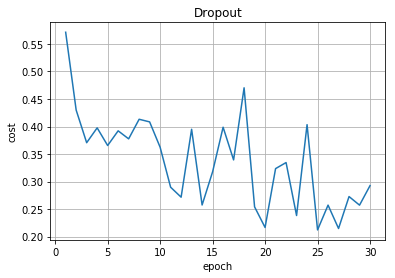

In [5]:
import data_loader
#from nn_overfitting import NN
import matplotlib.pyplot as plt

# load data
training_data, validation_data, test_data = data_loader.load()

# run NN
nn = NN([784, 100, 10])
cost = nn.train(training_data, 30, 10, 0.5, 0.0, 0.5)

correct = nn.evaluate(test_data)
total = len(test_data) 
print('Evaluation: {0} / {1} = {2}%'.format(correct, total, 100 * correct/total))

plt.title('Dropout')
plt.plot(np.arange(1, 31), cost)
plt.xlabel('epoch')
plt.ylabel('cost')
plt.grid()
plt.show()